# Reconstrucción de números escritos a mano con MLPr (MultiLayer Perceptron Regression)

In [1]:
%matplotlib inline

#Importamos las librerías a usar
import torch                                #Tensores
import torch.nn as nn                       #Redes
import torch.nn.functional as F             #Funciones de activación
from torchvision import datasets, transforms#Dataset

import numpy as np                          #Vectores/Arrays
import matplotlib.pyplot as plt             #Gráficas

#Averiguamos si es posible usar cuda
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
#Mostramos el resultado
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.12.1+cu102  Device: cuda


## Creación de los cargadores de datos.

In [2]:
#tamaño del batch o lotes
batch_size = 128

#Realizamos la trasformaciones a tensor y a un escalado
transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,)),
                                ])

#Descargamos el dataset de entrenamiento con MNIST
train_dataset = datasets.MNIST('/tmp/data', 
                               train=True, 
                               download=True, 
                               transform=transforms)

#Descargamos el dataset de validación con MNIST
validation_dataset = datasets.MNIST('/tmp/data', 
                                    train=False, 
                                    transform=transforms)

#Realizamos los cargadores de entrenamiento y validación con el tamaño de batch establecido anteriormente
#Cargador de entrenamiento
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
#cargador de validación
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 25847729.63it/s]


Extracting /tmp/data/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 5914540.00it/s]


Extracting /tmp/data/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 7585568.11it/s]


Extracting /tmp/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10154866.08it/s]

Extracting /tmp/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/data/MNIST/raw



The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [3]:
#Mostramos los tamaños de los lotes, viéndose 128 del lote, 1 capa de la imagen, 28 y 28 del tamaño de la imagen 
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([128, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([128]) type: torch.LongTensor


Mostramos los 10 primeros dígitos:

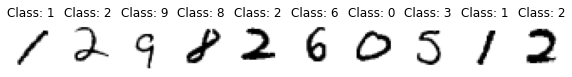

In [4]:
pltsize=1
#creamos un "marco" para mostrar 10 figuras
plt.figure(figsize=(10*pltsize, pltsize))

#Recorremos 10 figuras del ultimo lote obtenido en el anterior código
for i in range(10):
    #Creamos division de 1 a 10 figuras y las posicionamos en su orden
    plt.subplot(1,10,i+1)
    plt.axis('off')
    #Mostramos la i-esima imagen, eliminando la dimension de la capa para que la imagen sea solo de 28x28
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

## Definición del modelo MLP.

Este modelo tiene 3 capas: La primera con 50 neuronas, la segunda con 5, la tercera con 50 y la de salida con 784.
Función de activación Sigmoide excepto para la última que no tendrá ninguna.



In [5]:
#Definimos la red 
class Net(nn.Module):
    #Definición de la topografía de la red
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50) #Primera capa. Entrada de la imagen rgb de 28*28 a una salida de 50
        self.fc2 = nn.Linear(50, 5)     #Segunda capa. Entrada de 50 a 5
        self.fc3 = nn.Linear(5, 50)     #Tercera capa. Entrada de 5 a 50
        self.fc4 = nn.Linear(50, 28*28) #Ultima capa. Entrada de 50 a 784 

    #Definición de funciones de activación
    def forward(self, x):
        x = x.view(-1, 28*28)       #pasamos al matriz 28x28 a vector de una dimensión.
        x = F.sigmoid(self.fc1(x))  #Sigmoide en la primera capa
        x = F.sigmoid(self.fc2(x))  #Sigmoide en la segunda capa
        x = F.sigmoid(self.fc3(x))  #Sigmoide en la tercera capa
        return self.fc4(x)          #Terminamos con la ultima capa sin función de activación

## Creación del modelo, optimizador y función de pérdida.


In [6]:
#Instanciamos la red con el dispositivo establecido en el primer código, cuda o cpu
model = Net().to(device)
#Creamos el optimizador tipo Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#Usamos MSE para la función de perdida
criterion = nn.MSELoss()

#Imprimimos el resultado de como a quedado la red
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=784, bias=True)
)


## Learning

Definición del método de entrenamiento `train()` y del método de validación `validate()`. 

In [7]:
#Función de entrenamiento
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, _) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # matriz a vector
        target = data.view(-1, 28*28)
        
        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        #Cada intervalo ponemos un mensaje de progreso
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [8]:
#Función de activación
def validate(loss_vector):
    #Ponemos el modelo en modo validación
    model.eval()
    val_loss, correct = 0, 0

    #Recorremos el cargador de validación
    for data, _ in validation_loader:
        #Copiamos en GPU si fuera posible
        data = data.to(device)
        #Obtenemos perdición del lote
        output = model(data)
        #Convertimos el resultado en un vector
        target = data.view(-1, 28*28)
        #Calculamos el loss y acumulamos, .data.item() para sacar el valor del tensor
        val_loss += criterion(output, target).data.item()

    #Hacemos media del loss para introducirlo a una lista, para ver el progreso
    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)
   
    #Mostramos los valores actuales
    print('\nValidation set: Average loss: {:.4f}.\n'.format(val_loss))


In [9]:
#Función para reconstrucción del numero a una imagen 
def get_reconstruction():
    #Ponemos el modelo en modo validación
    model.eval()
    val_loss, correct = 0, 0
    #Recorremos el cargador de validación
    for data, _ in validation_loader:
        #Copiamos en GPU si fuera posible
        data = data.to(device)
        #Obtenemos perdición del lote
        output = model(data)
        #Convertimos el resultado en un 128 imágenes de 28x28 de una capa
        output = output.reshape(128,1,28,28)
        #Extraemos el mosaico de la primer imagen 
        mosaic = np.hstack((data[0].cpu().numpy().reshape(28,28), output[0].detach().cpu().numpy().reshape(28,28)))#[0]
        #solo queremos el primer lote, sera utilizado para visualización del progreso de la red
        break
    #devolvemos la imagen 
    return mosaic

# Bucle de entrenamiento

Por cada epoch, vamos a entrenar y después a validar el modelo. Finalmente en cada epoch, mostramos la imagen de reconstrucción

/home/alfith/.local/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 1.112931
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.717650
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.682358

Validation set: Average loss: 0.6401.



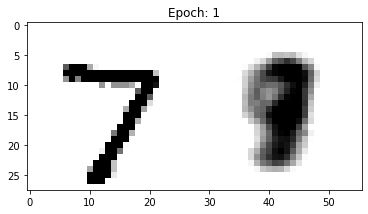

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.612269
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.578619
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.547107

Validation set: Average loss: 0.5559.



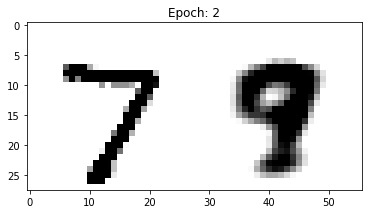

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.558291
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.556371
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.526979

Validation set: Average loss: 0.5135.



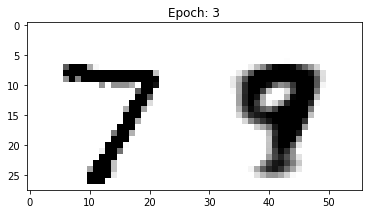

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.516813
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.508331
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.516162

Validation set: Average loss: 0.5058.



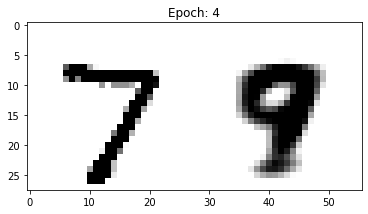

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.532421
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.514256
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.481712

Validation set: Average loss: 0.4789.



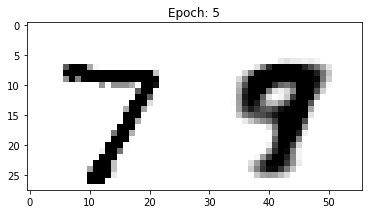

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.467446
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.470692
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.469219

Validation set: Average loss: 0.4712.



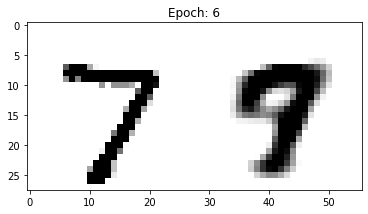

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.488247
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.477153
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.477017

Validation set: Average loss: 0.4693.



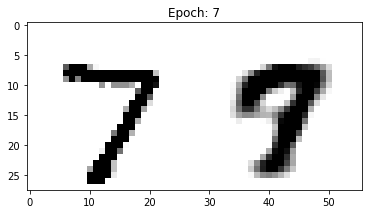

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.454510
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.476305
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.475474

Validation set: Average loss: 0.4674.



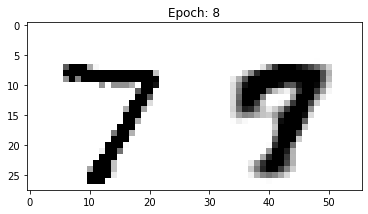

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.475820
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.489591
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.470853

Validation set: Average loss: 0.4645.



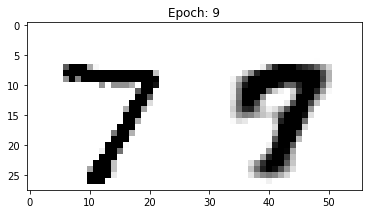

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.448091
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.455671
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.473897

Validation set: Average loss: 0.4592.



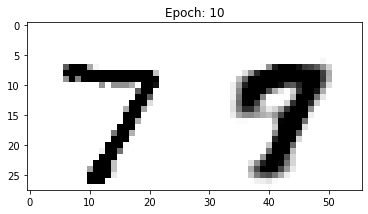

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.460109
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.453023
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.458593

Validation set: Average loss: 0.4514.



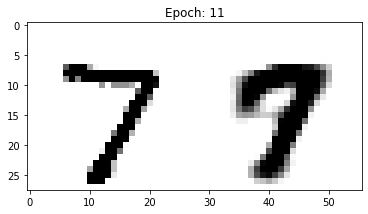

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.437187
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.455583
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.428319

Validation set: Average loss: 0.4425.



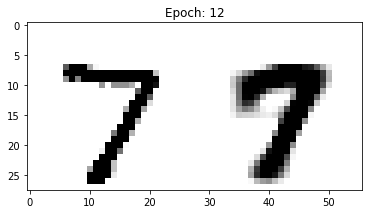

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.455940
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.447957
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.424657

Validation set: Average loss: 0.4336.



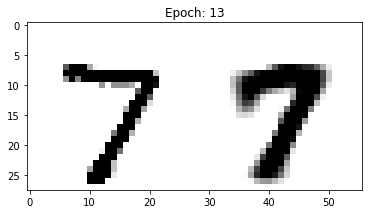

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.430224
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.445767
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.410925

Validation set: Average loss: 0.4255.



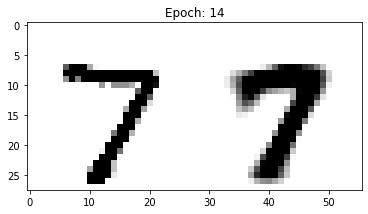

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.419529
Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.441515
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.414831

Validation set: Average loss: 0.4182.



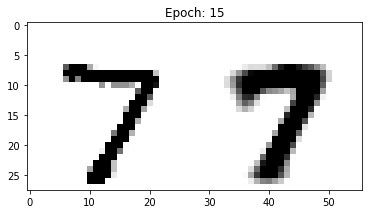

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.417006
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.402652
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.424591

Validation set: Average loss: 0.4120.



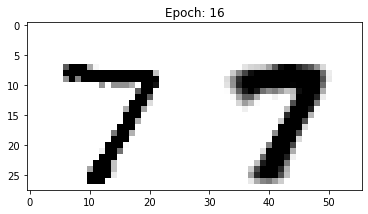

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.417213
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.418228
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.394536

Validation set: Average loss: 0.4060.



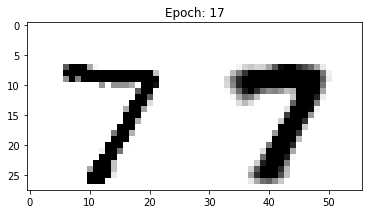

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.400903
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.426100
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.411887

Validation set: Average loss: 0.4014.



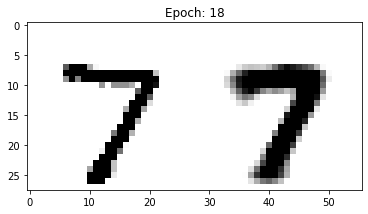

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.408773
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.394713
Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.419966

Validation set: Average loss: 0.3967.



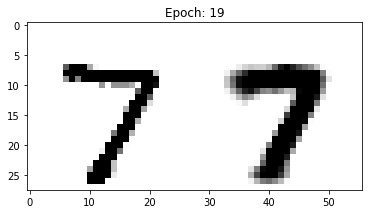

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.381443
Train Epoch: 20 [25600/60000 (43%)]	Loss: 0.403740
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.399090

Validation set: Average loss: 0.3934.



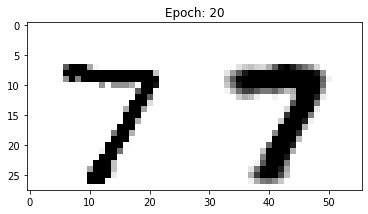

CPU times: user 2min 59s, sys: 5.78 s, total: 3min 5s
Wall time: 3min


In [10]:
%%time
#se realizara 20 épocas
epochs = 20

lossv = []
#Realizamos la 20 épocas de entrenamiento, validación y reconstrucción
for epoch in range(1, epochs + 1):
    #Entrenar 
    train(epoch)
    #Validar
    validate(lossv)
    #Obtenemos la representación del primer numero según la red
    mosaic = get_reconstruction()
    #Mostramos la imagen 
    plt.imshow(mosaic, cmap="gray_r", vmin=0, vmax=1)
    plt.title('Epoch: ' + str(epoch))
    plt.show()

Visualización del proceso de entrenamiento

* *Loss* diferencia entre la salida del modelo y la real.  Hay que minimizarla hasta 0, para ello usamos el optimizador.
* *Accuracy* es la precisión del modelo.

Text(0.5, 1.0, 'validation loss')

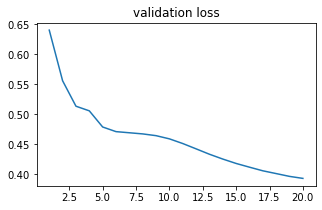

In [11]:
#Mostramos los resultados en gráficas
#loss de validación
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')
